## Multi-task problem: colored MNIST

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Colored [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* Size of each image: 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set
* We colorize each image with a random color within 7 (red, green, blue, magenta, yellow, cyan, white)
* Each image has two labels: the number it represents (10 classes) and the color of the number (7 classes)

In [84]:
# Given a loaded MNIST dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
        [0.0, 1.0, 1.0], # 5 CYAN
        [1.0, 1.0, 1.0], # 6 WHITE
    ])
    N = len(dataset)
    images = dataset.data.view(N, 1, 28, 28)
    labels = dataset.targets.view(N, 1)
    color_labels = torch.randint(0, 6, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [85]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

In [86]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([60000, 3, 28, 28])


In [87]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image label: tensor([9, 1])')

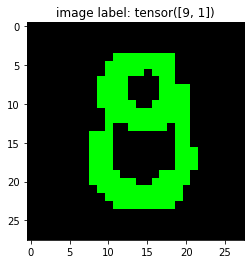

In [88]:
sample_index = 80

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), interpolation='nearest')
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [89]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        # self.l_number = nn.Linear(28*28*3, 10)
        # self.l_color = nn.Linear(28*28*3, 7)
        self.conv1 = nn.Conv2d(3, 392, 3)
        self.conv2 = nn.Conv2d(392, 128, 3)
        self.fc1 = nn.Linear(3200, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc_number = nn.Linear(32, 10)
        self.fc_color = nn.Linear(32, 10)
        
    def forward(self, x):
        # h = x.view(-1, 28*28*3)
        # Use softmax as the activation function for the last layer(s)
        # output_number = F.softmax(self.l_number(x), dim=1)
        # output_color = F.softmax(self.l_color(x), dim=1)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        output_number = self.fc_number(x)
        output_color = self.fc_color(x)
        
        return (output_number, output_color)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [104]:
# Create the model: 
model = Model()
model.to(device)

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 16

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

In [105]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            (y_number, y_color) = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            number_onehot = F.one_hot(labels[:,0], 10).float()
            color_onehot = F.one_hot(labels[:,1], 7).float()
            
            # loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            loss = criterion(y_number, labels[:,0]) + criterion(y_color, labels[:,1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [106]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/20], Loss: 1.8334
Epoch [2/20], Loss: 0.3649
Epoch [3/20], Loss: 0.1482
Epoch [4/20], Loss: 0.1269
Epoch [5/20], Loss: 0.0728
Epoch [6/20], Loss: 0.0669
Epoch [7/20], Loss: 0.0471
Epoch [8/20], Loss: 0.0446
Epoch [9/20], Loss: 0.0363
Epoch [10/20], Loss: 0.0472
Epoch [11/20], Loss: 0.0370
Epoch [12/20], Loss: 0.0308
Epoch [13/20], Loss: 0.0300
Epoch [14/20], Loss: 0.0159
Epoch [15/20], Loss: 0.0378
Epoch [16/20], Loss: 0.0239
Epoch [17/20], Loss: 0.0295
Epoch [18/20], Loss: 0.0233
Epoch [19/20], Loss: 0.0274
Epoch [20/20], Loss: 0.0180


Text(0.5, 1.0, 'Visualization of convergence')

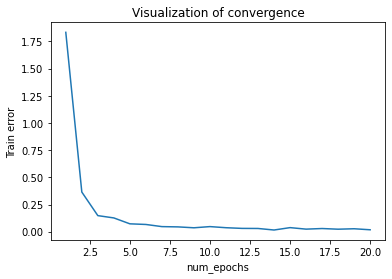

In [107]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the model on the validation set

In [112]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # images = images.view(-1, 28*28)
            (y_number, y_color) = model(images.to(device))
            labels.to(device)
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))

In [113]:
accuracy(val_set, model)

Accuracy of the model for numbers : 98.55 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 98.55 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction: number=1, color=5')

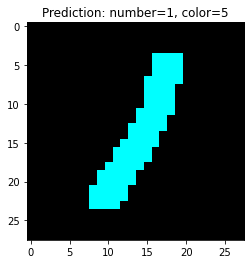

In [119]:
val_index = 66

(image, label) = val_set[val_index]

(y_number, y_color) = model(image.unsqueeze(0).to(device))
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [120]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)
test_set = colorize_dataset(test_set)

In [121]:
accuracy(test_set, model)

Accuracy of the model for numbers : 98.82 %
Accuracy of the model for colors : 99.99 %
Accuracy of the model for both : 98.81 %
